In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import pickle
import string
import wikipediaapi
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
# Install the better-profanity module
%pip install better-profanity

from better_profanity import profanity

# Load the profanity filter with its default list
profanity.load_censor_words()

c:\Users\vivek\anaconda3\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import pipeline

def generate_synthetic_text(prompts, num_sentences=5, file_name="synthetic_text.txt"):
    generator = pipeline("text-generation", model="gpt2")
    data = ""
    
    for prompt in prompts:
        result = generator(prompt, max_length=50, num_return_sequences=num_sentences)
        for output in result:
            data += output['generated_text'] + "\n"
    
    with open(file_name, "w", encoding="utf-8") as f:
        f.write(data)
    
    print("✅ Synthetic dataset saved successfully!")

# Example Prompts
prompts = ["Once upon a time in a distant land,", "The future of artificial intelligence is"]
generate_synthetic_text(prompts)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ Synthetic dataset saved successfully!


In [3]:
# Example Prompts
prompts = ["Once upon a time in a distant land,", "The future of artificial intelligence is"]
generate_synthetic_text(prompts)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ Synthetic dataset saved successfully!


In [17]:
# Data Loading & Preprocessing
dataset_path = 'combined_dataset.txt'
with open(dataset_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [18]:
# Basic cleaning (lowercase and strip extra spaces)
text_data = text_data.lower().strip()

In [19]:
# Tokenization and saving tokenizer for later use
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

In [20]:
# Convert text to sequences
sequence_data = tokenizer.texts_to_sequences([text_data])[0]
vocab_size = len(tokenizer.word_index) + 1

In [21]:
# Tokenize the text using Keras Tokenizer
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts([text_data])
total_words = len(tokenizer_lstm.word_index) + 1

In [22]:
# Create sequences with 5-word context
sequence_length = 5
sequences = []
for i in range(sequence_length, len(sequence_data)):
    sequences.append(sequence_data[i - sequence_length:i + 1])
sequences = np.array(sequences)

In [23]:
# Prepare input (X) and output (y)
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)
X = pad_sequences(X, maxlen=sequence_length, padding='pre')

In [24]:
# For demonstration, using random embeddings
embedding_dim = 100
embedding_matrix = np.random.uniform(-1, 1, (vocab_size, embedding_dim))

In [25]:
# Create input sequences (n-gram sequences)
input_sequences = []
for line in text_data.split('\n'):
    token_list = tokenizer_lstm.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [26]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=sequence_length, trainable=True),
    Bidirectional(LSTM(256, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(256)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [27]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [28]:
# Early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)


In [29]:
# Train the model
model.fit(X, y, epochs=50, batch_size=256, verbose=1, callbacks=[early_stopping, lr_reduction])


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.0366 - loss: 6.7434 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.0890 - loss: 5.6362 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.1186 - loss: 5.2041 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.1352 - loss: 4.8405 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.1582 - loss: 4.4642 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.1797 - loss: 4.1379 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.2065 - loss: 3.7892 - learning_rate: 0.0010
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.2497 - loss: 3.4116 - learning_rate: 0.0010
Epoch 9/50
19/87 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.3126 - loss: 2.9607

KeyboardInterrupt: 

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.7593 - loss: 0.8449 - val_accuracy: 0.6657 - val_loss: 1.1600 - learning_rate: 0.0010
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.7622 - loss: 0.8321 - val_accuracy: 0.6514 - val_loss: 1.2703 - learning_rate: 0.0010
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.7715 - loss: 0.8069 - val_accuracy: 0.6398 - val_loss: 1.3470 - learning_rate: 0.0010
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.7809 - loss: 0.7672 - val_accuracy: 0.6174 - val_loss: 1.4494 - learning_rate: 0.0010
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.8111 - loss: 0.6581 - val_accuracy: 0.6351 - val_loss: 1.3602 - learning_rate: 5.0000e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.8412 - loss: 0.5298 - val_accuracy: 0.6448 - val_loss: 1.3279 - learning_rate: 5.0000e-04


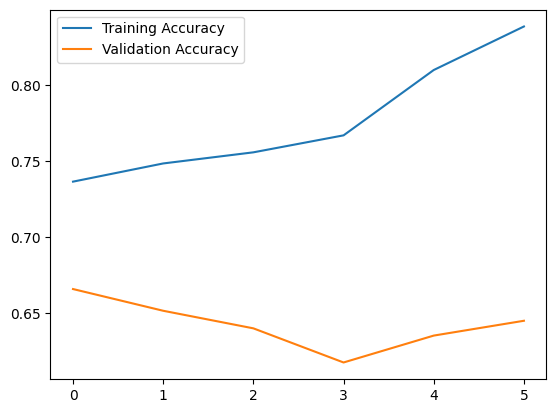

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Adjust callbacks with a bit more patience for learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

history = model.fit(X, y, epochs=10, batch_size=64, verbose=1,
                    callbacks=[early_stopping, lr_reduction],
                    validation_split=0.2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Pad sequences
max_sequence_len = max(len(seq) for seq in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
# Split predictors and labels for training the LSTM (optional)
xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Load the BERT fill-mask pipeline (pre-trained model provided)
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

def predict_next_word_bert(text):
    """
    Predicts the next word using BERT's masked language model.
    It appends a [MASK] token at the end of the input text.
    """
    masked_text = text + " [MASK]."  # Append mask token for prediction
    predictions = fill_mask(masked_text)
    
    print(f"\n🔹 Input: {text}")
    for idx, prediction in enumerate(predictions[:3]):  # Display top 3 predictions
        word = prediction['token_str']
        confidence = prediction['score'] * 100
        print(f"   ➤ Prediction {idx+1}: {word} ({confidence:.2f}%)")
    
    # Return the top predicted word
    return predictions[0]['token_str']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [ ]:
# %%
# Example Usage
input_sentence = "give me the best price"
next_word = predict_next_word_bert(input_sentence)
print(f"\n✅ Predicted next word: {next_word}")


🔹 Input: give me the best price
   ➤ Prediction 1: possible (48.34%)
   ➤ Prediction 2: ever (43.73%)
   ➤ Prediction 3: available (1.18%)

✅ Predicted next word: possible


In [ ]:
# For example, using input() in a terminal or ipywidgets in a notebook.
user_input = input("Enter your prompt (without the next word): ")
predicted = predict_next_word_bert(user_input)
print(f"\nPredicted next word: {predicted}")


🔹 Input: Hello ! Good
   ➤ Prediction 1: morning (75.54%)
   ➤ Prediction 2: afternoon (6.61%)
   ➤ Prediction 3: evening (5.45%)

Predicted next word: morning


In [ ]:
# Function to store user input data for later tokenizer updates
def store_user_input(text):
    with open("user_data.txt", "a", encoding="utf-8") as f:
        f.write(text + "\n")

# Function to update the tokenizer with new user data
def update_tokenizer():
    try:
        with open("user_data.txt", "r", encoding="utf-8") as f:
            new_text_data = f.read()
        global tokenizer
        tokenizer.fit_on_texts([new_text_data])
        pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))
        print("✅ Tokenizer updated successfully!")
    except Exception as e:
        print(f"❌ Error updating tokenizer: {e}")

In [ ]:
# Load the BERT fill-mask pipeline for next word prediction
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

# Function to predict the next word using BERT while filtering out profanities
def predict_next_word_bert(text):
    masked_text = text + " [MASK]."  # Append mask token for prediction
    predictions = fill_mask(masked_text)
    
    print(f"\n🔹 Input: {text}")
    # Display top 3 predictions with filtering
    for idx, prediction in enumerate(predictions[:3]):
        word = prediction['token_str']
        if not profanity.contains_profanity(word):
            print(f"   ➤ Prediction {idx+1}: {word} ({prediction['score']*100:.2f}%)")
        else:
            print(f"   ➤ Prediction {idx+1}: [Filtered]")
    
    # Return the first non-offensive word; if none found, return a default word
    for prediction in predictions:
        if not profanity.contains_profanity(prediction['token_str']):
            return prediction['token_str']
    return "word"

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [ ]:
# Function to iteratively predict the next num_words words
def Predict_Next_Words(text, num_words):
    store_user_input(text)  # Save user input for future tokenizer updates
    predicted_sentence = text
    for _ in range(num_words):
        next_word = predict_next_word_bert(predicted_sentence)
        predicted_sentence += " " + next_word.strip()
    return predicted_sentence

# Example Usage
input_sentence = "give me the best price"
next_word = predict_next_word_bert(input_sentence)
print(f"\n✅ Predicted next word: {next_word}")

user_input = input("Enter your prompt (without the next word): ")
predicted = Predict_Next_Words(user_input, 3)
print(f"\nPredicted sentence: {predicted}")

# Optionally, update the tokenizer after predictions
update_tokenizer()


🔹 Input: give me the best price
   ➤ Prediction 1: possible (48.34%)
   ➤ Prediction 2: ever (43.73%)
   ➤ Prediction 3: available (1.18%)

✅ Predicted next word: possible

🔹 Input: Good morning
   ➤ Prediction 1: everyone (3.93%)
   ➤ Prediction 2: sir (2.41%)
   ➤ Prediction 3: everybody (1.05%)

🔹 Input: Good morning everyone
   ➤ Prediction 1: ##s (27.60%)
   ➤ Prediction 2: else (5.95%)
   ➤ Prediction 3: here (5.11%)

🔹 Input: Good morning everyone ##s
   ➤ Prediction 1: ! (1.32%)
   ➤ Prediction 2: mr (1.22%)
   ➤ Prediction 3: " (1.09%)

Predicted sentence: Good morning everyone ##s !
✅ Tokenizer updated successfully!
